In [1]:
%load_ext autoreload
%autoreload 2

# Learning the Swiss Roll on Simplex with Statistical Flow Matching

In this notebook, we demonstrate how to train SFM, SFM Naive, and LinearFM on the Swiss Roll dataset as a toy example. You will need to install `plotly` to visualize the results. Run `pip install plotly` to install it.

The Swiss Roll dataset is a 3-class dataset on the 2-simplex by normalizing the 2D Swiss roll to $[0+\varepsilon,1-\varepsilon]$ where $\varepsilon$ is a small margin.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, Image
import numpy as np

from models import SphereCategoricalFlow, SimplexCategoricalFlow, LinearCategoricalFlow
from datasets.swissroll import make_swiss_roll
from utils import seed_all

[WARNING]: dependencies for TSSDatasetS not installed, skipping import


We then define the vector field predictor, which is based on simple multi-layer perceptions (MLPs) on time embeddings and coordinates.

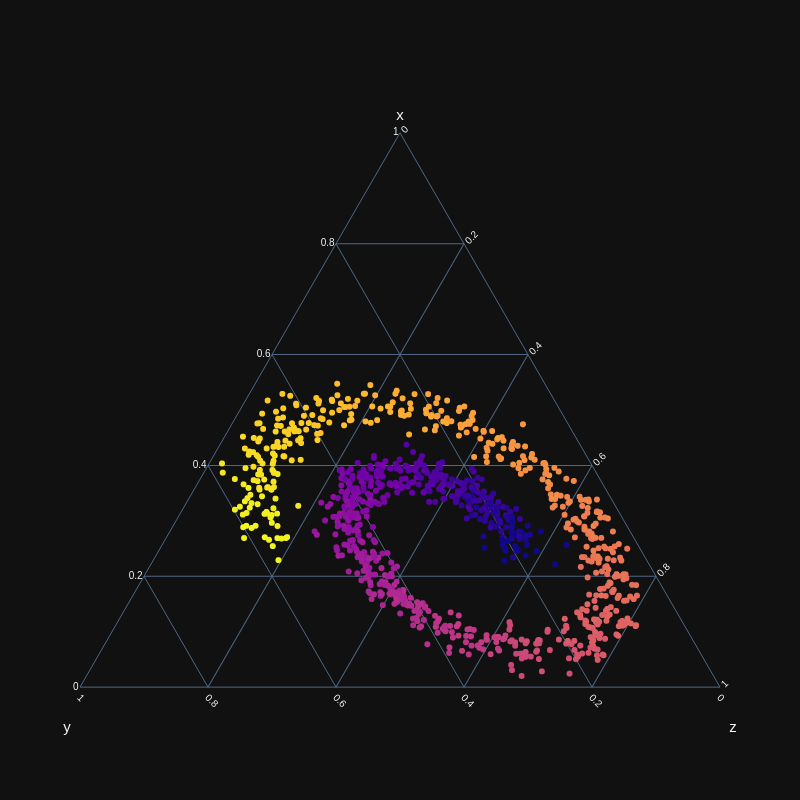

In [3]:
import plotly.graph_objects as go

static_fig = True


def makeAxis(title, tickangle):
    return {
        'title': title,
        'titlefont': {'size': 15},
        'tickangle': tickangle,
        'tickfont': {'size': 10},
        'tickcolor': 'rgba(0,0,0,0)',
        'ticklen': 5,
        'showline': True,
        'showgrid': True
    }


def plot_ternary(x, y, z, t=None):
    fig = go.Figure(go.Scatterternary({
        'mode': 'markers',
        'a': x,
        'b': y,
        'c': z,
        'marker': {
            'color': t,
        }
    }))
    fig.update_layout({
        'ternary': {
            'sum': 1,
            'aaxis': makeAxis('x', 0),
            'baxis': makeAxis('<br>y', 45),
            'caxis': makeAxis('<br>z', -45)
        },
        'annotations': [{
            'showarrow': False,
            'text': 'Ternary Plot',
            'x': 0.5,
            'y': 1.3,
            'font': {'size': 15}
        }],
        'width': 800,
        'height': 800,
    })
    if static_fig:
        display(Image(fig.to_image(format='png')))
    else:
        fig.show()


X, _t = make_swiss_roll(n_samples=1000, noise=1., pad=1., seed=42)
plot_ternary(X[:, 0], X[:, 1], X[:, 2], _t)

In [4]:
def get_time_embedding(timesteps, embedding_dim, max_positions=2000):
    # Code from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    assert len(timesteps.shape) == 1
    timesteps = timesteps * max_positions
    half_dim = embedding_dim // 2
    emb = np.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), mode='constant')
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb


class Encoder(nn.Module):
    def __init__(self, input_size=3, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.in_fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.t_fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 2 * hidden_size),
            nn.ReLU(),
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x, t):
        x = self.in_fc(x)
        t = self.t_fc(get_time_embedding(t, self.hidden_size)).unsqueeze(1).expand_as(x)
        return self.fc(torch.cat((x, t), dim=-1))

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


def train(model, n_epoch=2000, lr=1e-3, log_epoch=200):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epoch):
        model.train()
        optimizer.zero_grad()
        loss = model.get_loss(X.unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()
        if epoch % log_epoch == 0:
            print(f'Epoch {epoch}, loss {loss.item():.4f}')
            model.eval()
            with torch.no_grad():
                nll = model.compute_nll_ode(X.unsqueeze(1).to(device), 500, verbose=False)
                print(f'NLL: {nll.item():.4f}')
    print('Done!')


def sample(model, n_sample=1000, method='ode', n_step=1000):
    model.eval()
    with torch.no_grad():
        X_gen = model.sample(method, n_sample, n_step, device).detach().cpu().numpy()
    plot_ternary(X_gen[:, 0, 0], X_gen[:, 0, 1], X_gen[:, 0, 2])


def cal_nll(model, n_repeat=20, method='ode', n_step=500):
    nlls = []
    model.eval()
    with torch.no_grad():
        for _ in range(n_repeat):
            nll = model.compute_nll(method, X.unsqueeze(1).to(device), n_step)
            nlls.append(nll.item())
            print(f'NLL: {sum(nlls) / len(nlls):.4f}')
    nlls = np.array(nlls)
    print(f'Avg NLL: {nlls.mean():.4f} ± {nlls.std():.4f}')

## SFM

We train the SFM model on the Swiss Roll dataset and calculate the negative log-likelihood (NLL). SFM utilizes the diffeomorphism between the 2-simplex and the 2-sphere as:
$$
\pi: \mathcal{P} \to S_+^{n-1}, \quad \mu_i \mapsto x_i=\sqrt{\mu_i}.
$$

Epoch 0, loss 0.2436
NLL: -0.7176
Epoch 200, loss 0.1506
NLL: -1.7717
Epoch 400, loss 0.1534
NLL: -1.8363
Epoch 600, loss 0.1552
NLL: -2.0271
Epoch 800, loss 0.1446
NLL: -2.1683
Epoch 1000, loss 0.1528
NLL: -2.1360
Epoch 1200, loss 0.1510
NLL: -2.0676
Epoch 1400, loss 0.1515
NLL: -2.2046
Epoch 1600, loss 0.1521
NLL: -2.3221
Epoch 1800, loss 0.1493
NLL: -2.3625
Done!


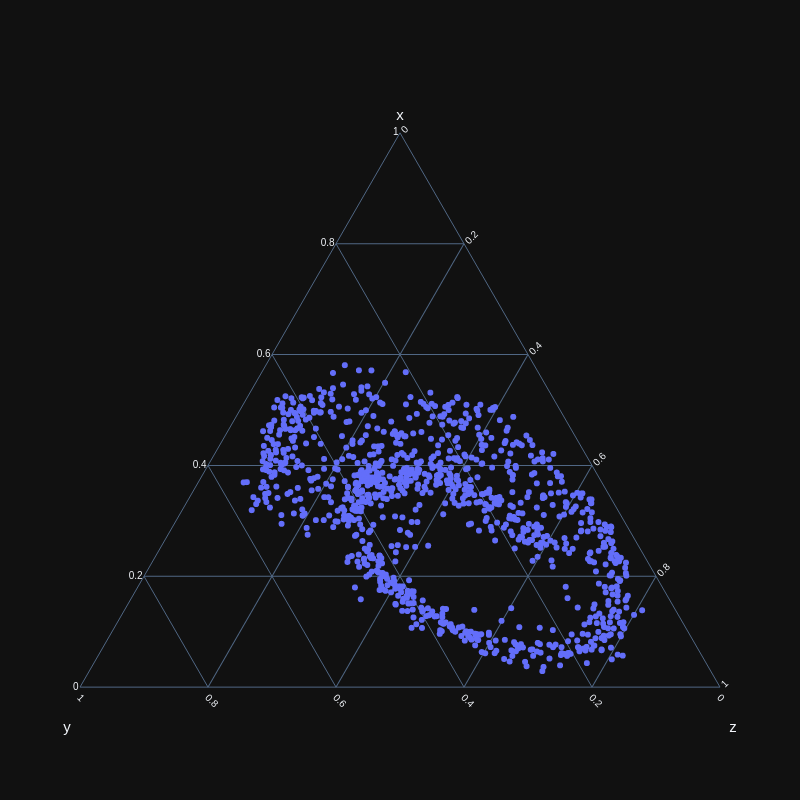

In [6]:
seed_all(42)
sfm = SphereCategoricalFlow(Encoder(3, 128), (1,), 3, ot=False).to(device)
train(sfm, 2000)
sample(sfm, 1000, 'ode')

In [7]:
cal_nll(sfm, 20, method='ode')
nll = sfm.compute_nll('ode', X.unsqueeze(1).to(device), 500, exact=True, verbose=True)
print(f'Exact NLL: {nll:.4f}')

NLL: -2.1970
NLL: -2.1902
NLL: -2.2110
NLL: -2.2318
NLL: -2.2495
NLL: -2.2555
NLL: -2.2686
NLL: -2.2601
NLL: -2.2512
NLL: -2.2434
NLL: -2.2437
NLL: -2.2550
NLL: -2.2543
NLL: -2.2587
NLL: -2.2609
NLL: -2.2687
NLL: -2.2657
NLL: -2.2665
NLL: -2.2728
NLL: -2.2683
Avg NLL: -2.2683 ± 0.0698
logp0: 0.6931, logdetjac: 2.1349, logt0: -1.0551, logt1: 0.5216
Exact NLL: -2.2946


## SFM Naive

In the naive version of SFM, we directly work with the statistical manifold of categorical distributions and uses the exponential and logarithm maps for training the flow.

Epoch 0, loss 0.9946
NLL: -0.7120
Epoch 200, loss 0.6777
NLL: -1.3001
Epoch 400, loss 0.6578
NLL: -1.3488
Epoch 600, loss 0.6515
NLL: -1.4560
Epoch 800, loss 0.5983
NLL: -1.5863
Epoch 1000, loss 0.6263
NLL: -1.6382
Epoch 1200, loss 0.6298
NLL: -1.5078
Epoch 1400, loss 0.6137
NLL: -1.6340
Epoch 1600, loss 0.6253
NLL: -1.8295
Epoch 1800, loss 0.6198
NLL: -1.6833
Done!


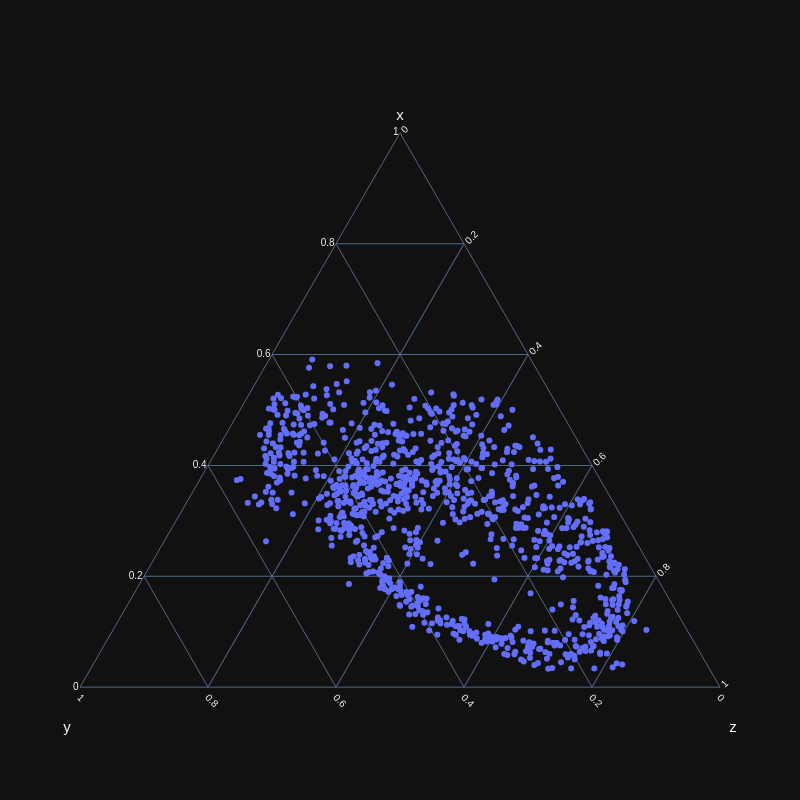

In [8]:
seed_all(42)
sfm_simplex = SimplexCategoricalFlow(Encoder(3, 128), (1,), 3, ot=False).to(device)
train(sfm_simplex, 2000)
sample(sfm_simplex, 1000, 'ode')

In [9]:
cal_nll(sfm_simplex, 20, method='ode')
nll = sfm_simplex.compute_nll('ode', X.unsqueeze(1).to(device), 500, exact=True, verbose=True)
print(f'Exact NLL: {nll:.4f}')

NLL: -1.6719
NLL: -1.6550
NLL: -1.6721
NLL: -1.6900
NLL: -1.7012
NLL: -1.7103
NLL: -1.7302
NLL: -1.7215
NLL: -1.7167
NLL: -1.7121
NLL: -1.7139
NLL: -1.7069
NLL: -1.7092
NLL: -1.7096
NLL: -1.7114
NLL: -1.7176
NLL: -1.7156
NLL: -1.7137
NLL: -1.7140
NLL: -1.7080
Avg NLL: -1.7080 ± 0.0588
logp0: 0.6931, logdetjac: 1.0343, logt0: 0.0000, logt1: 0.0000
Exact NLL: -1.7274


## LinearFM

The linear flow matching model simply assumes an underlying Euclidean structure for the manifold of categorical distributions.

Epoch 0, loss 0.2607
NLL: -0.7107
Epoch 200, loss 0.1561
NLL: -1.5622
Epoch 400, loss 0.1595
NLL: -1.6191
Epoch 600, loss 0.1595
NLL: -1.7275
Epoch 800, loss 0.1478
NLL: -1.6739
Epoch 1000, loss 0.1546
NLL: -1.7566
Epoch 1200, loss 0.1577
NLL: -1.6151
Epoch 1400, loss 0.1578
NLL: -1.8184
Epoch 1600, loss 0.1553
NLL: -2.0042
Epoch 1800, loss 0.1523
NLL: -1.8565
Done!


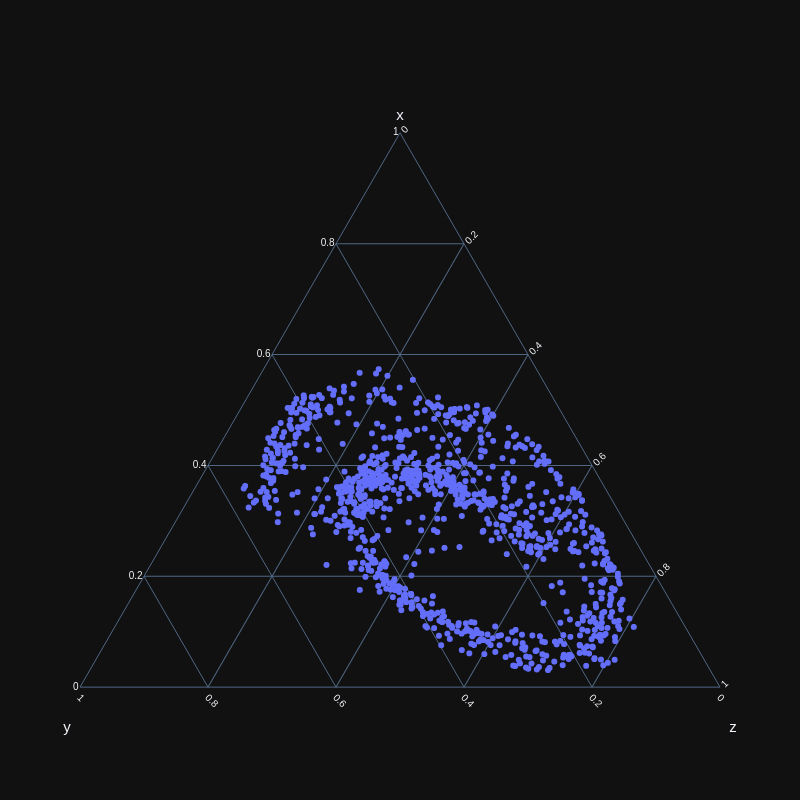

In [10]:
seed_all(42)
lfm = LinearCategoricalFlow(Encoder(3, 128), (1,), 3, ot=False).to(device)
train(lfm, 2000)
sample(lfm, 1000, 'ode')

In [11]:
cal_nll(lfm, 20, method='ode')
nll = lfm.compute_nll('ode', X.unsqueeze(1).to(device), 500, exact=True, verbose=True)
print(f'Exact NLL: {nll:.4f}')

NLL: -1.8032
NLL: -1.8158
NLL: -1.8383
NLL: -1.8634
NLL: -1.8722
NLL: -1.8912
NLL: -1.9132
NLL: -1.9023
NLL: -1.8968
NLL: -1.8895
NLL: -1.8945
NLL: -1.8993
NLL: -1.8994
NLL: -1.8989
NLL: -1.9033
NLL: -1.9114
NLL: -1.9086
NLL: -1.9053
NLL: -1.9073
NLL: -1.9037
Avg NLL: -1.9037 ± 0.0688
logp0: 0.6931, logdetjac: 1.2336, logt0: 0.0000, logt1: 0.0000
Exact NLL: -1.9267
